In [45]:
# Import dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import requests
import json
from api_keys import geoapify_key
import hvplot.pandas

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

In [46]:
# Set CSV file path and import CSVs 
visa_data_path = Path("Data/ABS_NOM_VISA.csv")
gender_data_path = Path("Data/ABS_NOM_AGE-GENDER.csv")

visa_data_df = pd.read_csv(visa_data_path, encoding="utf-8")
gender_data_df = pd.read_csv(gender_data_path, encoding="utf-8")

In [47]:
# Check gender dataframe
gender_data_df.head()

,DATAFLOW,MEASURE: Measure,AGE: Age,SEX: Sex,REGION: Region,FREQ: Frequency,TIME_PERIOD: Time Period,OBS_VALUE,UNIT_MEASURE: Unit of Measure,OBS_STATUS: Observation Status,OBS_COMMENT: Observation Comment,REPYEAREND: Reporting Year End Day
0,ABS:NOM_FY(1.0.0),3: Net Overseas Migration,A30: 30-34,1: Males,3: Queensland,A: Annual,2005,1570,NUM: Number,NaN,NaN,30-6: Year Ending 30 June
1,ABS:NOM_FY(1.0.0),3: Net Overseas Migration,A30: 30-34,1: Males,3: Queensland,A: Annual,2006,2080,NUM: Number,NaN,NaN,30-6: Year Ending 30 June
2,ABS:NOM_FY(1.0.0),3: Net Overseas Migration,A30: 30-34,1: Males,3: Queensland,A: Annual,2007,2760,NUM: Number,NaN,NaN,30-6: Year Ending 30 June
3,ABS:NOM_FY(1.0.0),3: Net Overseas Migration,A30: 30-34,1: Males,3: Queensland,A: Annual,2008,2890,NUM: Number,NaN,NaN,30-6: Year Ending 30 June
4,ABS:NOM_FY(1.0.0),3: Net Overseas Migration,A30: 30-34,1: Males,3: Queensland,A: Annual,2009,3230,NUM: Number,NaN,NaN,30-6: Year Ending 30 June


In [48]:
# Filter out totals in table and remove unecessary columns 
gender_data_df = gender_data_df.loc[(gender_data_df["MEASURE: Measure"]) == "1: NOM arrivals"]
gender_data_df = gender_data_df.loc[(gender_data_df["AGE: Age"]) != "TOT: All ages"]
gender_data_df = gender_data_df.loc[(gender_data_df["REGION: Region"]) != "AUS: Australia"]
gender_data_df = gender_data_df[["AGE: Age", "SEX: Sex", "REGION: Region", "TIME_PERIOD: Time Period", "OBS_VALUE"]]
gender_data_df = gender_data_df.rename(columns={"AGE: Age":"Age", "SEX: Sex":"Sex", "REGION: Region": "Region", "TIME_PERIOD: Time Period":"Year", "OBS_VALUE": "Value"})
gender_data_df.head()

,Age,Sex,Region,Year,Value
72,A10: 10-14,2: Females,7: Northern Territory,2005,60
73,A10: 10-14,2: Females,7: Northern Territory,2006,60
74,A10: 10-14,2: Females,7: Northern Territory,2007,80
75,A10: 10-14,2: Females,7: Northern Territory,2008,100
76,A10: 10-14,2: Females,7: Northern Territory,2009,100


In [49]:
# Check totals 
total_arrivals = gender_data_df.groupby(["Year"])["Value"].sum()
total_arrivals_df = total_arrivals.reset_index()
total_arrivals_df

# Total arrivals agree to the ABS website 

,Year,Value
0,2005,341460
1,2006,376670
2,2007,437520
3,2008,501400
4,2009,519950
5,2010,438010
6,2011,431910
7,2012,467490
8,2013,482230
9,2014,464840


In [50]:
# Calculate % decrease in total migrant arrivals 
total_arrivals_df["% Change"] = total_arrivals_df["Value"].pct_change()
total_arrivals_df["% Change"] = (total_arrivals_df["% Change"]*100).map("{:.1f}%".format)
total_arrivals_df

,Year,Value,% Change
0,2005,341460,nan%
1,2006,376670,10.3%
2,2007,437520,16.2%
3,2008,501400,14.6%
4,2009,519950,3.7%
5,2010,438010,-15.8%
6,2011,431910,-1.4%
7,2012,467490,8.2%
8,2013,482230,3.2%
9,2014,464840,-3.6%


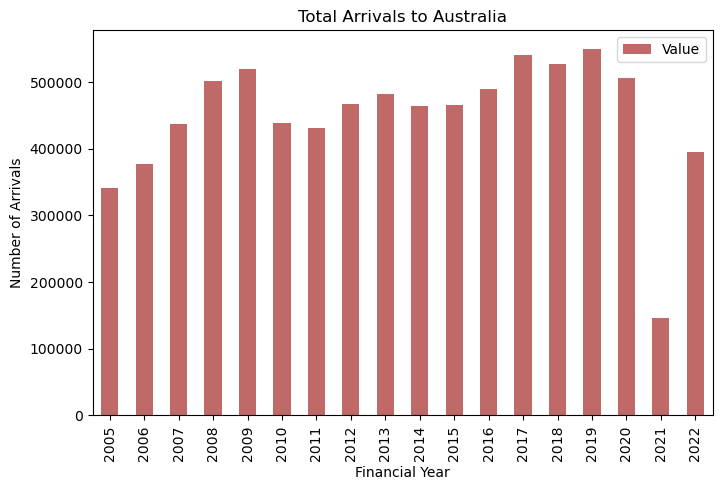

In [51]:
# Create a graph showing the total number of migration arrivals to Australia 
total_arrivals_df.plot(kind="bar", x="Year", y="Value", figsize=(8,5), title="Total Arrivals to Australia", alpha = 0.7, color = "brown")
plt.xlabel("Financial Year")
plt.ylabel("Number of Arrivals")
plt.legend(loc="best")
plt.show()

In [52]:
# Create a dataframe of the migration arrivals by year and region 
region_data = gender_data_df.groupby(["Year", "Region"])["Value"].sum()
region_data_df = region_data.reset_index() 
region_data_df = region_data_df.pivot(index="Year", columns="Region", values="Value")
region_data_df = region_data_df.rename(columns={"1: New South Wales":"NSW", "2: Victoria":"VIC", 
                                                "3: Queensland": "QLD", "4: South Australia":"SA",
                                                "5: Western Australia": "WA", "6: Tasmania": "TAS",
                                                "7: Northern Territory":"NT", "8: Australian Capital Territory":"ACT"})
region_data_df

Region,NSW,VIC,QLD,SA,WA,TAS,NT,ACT
Year,,,,,,,,
2005,125190,81270,65400,16620,40000,3160,4430,5390
2006,132750,89890,73090,20570,47190,3390,3950,5840
2007,150600,108600,86520,23520,53850,3430,4580,6420
2008,170960,123460,99680,25180,66140,3910,4720,7350
2009,169040,132690,103140,27260,69730,4310,5550,8230
2010,144220,109140,84920,24820,57940,4020,4680,8270
2011,141980,104940,84280,20160,64950,3480,4850,7270
2012,140880,112290,93210,23000,78010,3800,6770,9530
2013,152640,119270,92850,22630,74400,3930,7820,8690


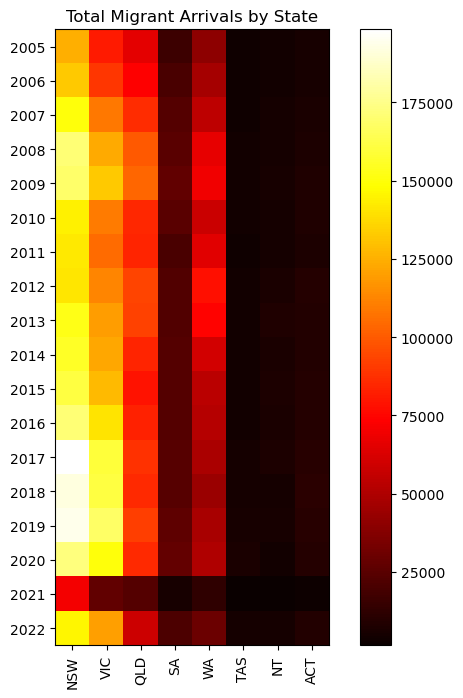

In [53]:
# Create a heat map of arrivals by region
plt.figure(figsize=(8, 8))
plt.title("Total Migrant Arrivals by State")
plt.imshow(region_data_df, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(region_data_df.columns)), region_data_df.columns, rotation = 90)
plt.yticks(range(len(region_data_df.index)), region_data_df.index)
plt.show()

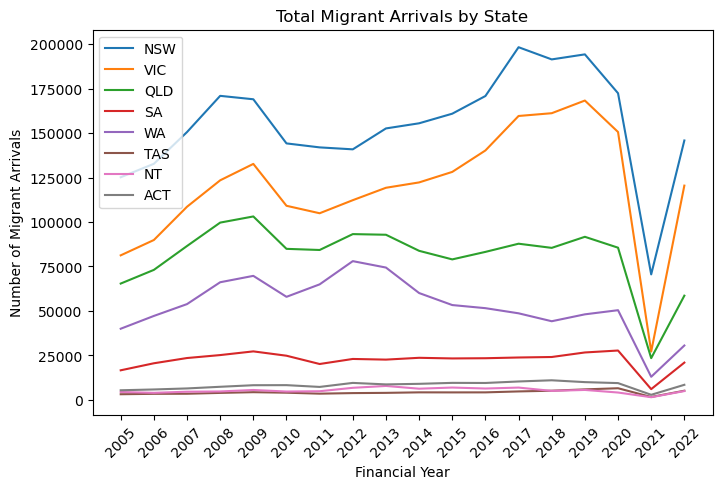

In [54]:
# Create a line graph of the regions by year
region_data_df.plot(kind="line", figsize=(8, 5), rot=45)
plt.legend(loc="best")
plt.title("Total Migrant Arrivals by State")
plt.xlabel("Financial Year")
plt.ylabel("Number of Migrant Arrivals")
plt.xticks(region_data_df.index)
plt.show()

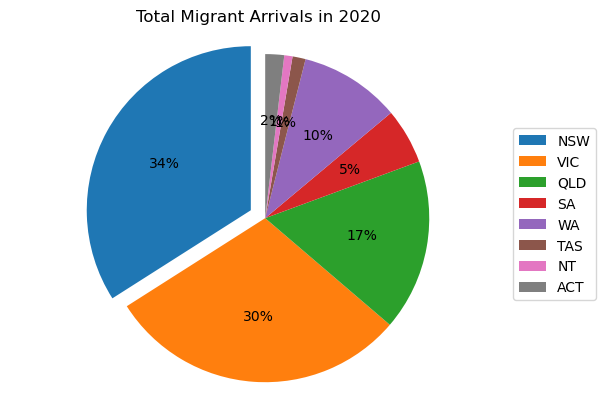

In [70]:
# What percentage of migrants arrivals are going to each region in 2020 (before COVID)
labels = region_data_df.columns
sizes = region_data_df.loc[2020] / region_data_df.loc[2020].sum() * 100
explode = (0.1, 0, 0, 0, 0, 0, 0, 0) 
plt.pie(sizes, explode=explode, labels=labels, autopct="%1.0f%%", startangle=90, labeldistance=None)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Total Migrant Arrivals in 2020")
plt.axis("equal")
plt.show()

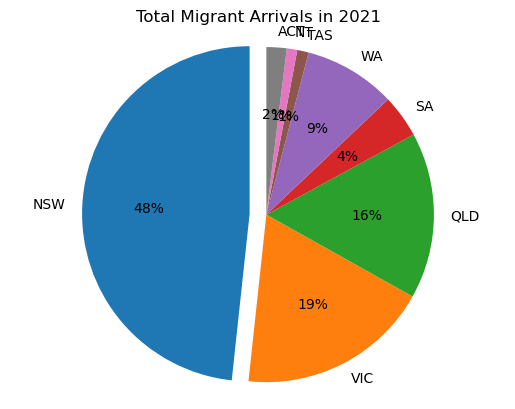

In [56]:
# What percentage of migrants arrivals are going to each region in 2021 (during COVID)
sizes3 = region_data_df.loc[2021] / region_data_df.loc[2021].sum() * 100
plt.pie(sizes3, explode=explode, labels=labels, autopct="%1.0f%%", startangle=90)
plt.title("Total Migrant Arrivals in 2021")
plt.axis("equal")
plt.show()

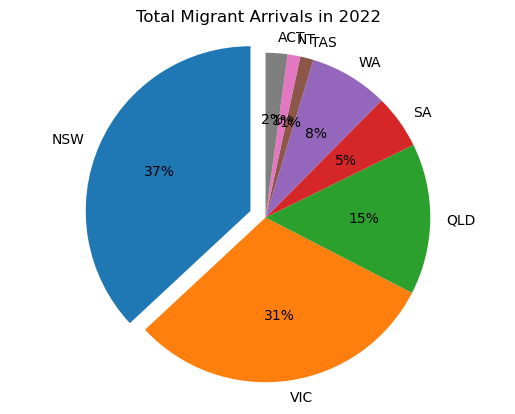

In [57]:
# What percentage of migrants arrivals are going to each region in 2022 (post COVID)
sizes2 = region_data_df.loc[2022] / region_data_df.loc[2022].sum() * 100
plt.pie(sizes2, explode=explode, labels=labels, autopct="%1.0f%%", startangle=90)
plt.title("Total Migrant Arrivals in 2022")
plt.axis("equal")
plt.show()

In [58]:
# Visualise map for migrant arrivals in 2022 
# Create dataframe to hold latitude and longitude
cities = ["Sydney", "Melbourne", "Brisbane", "Adelaide", 
          "Perth", "Hobart", "Darwin", "Canberra"]

city_data = {"City": cities,
           "Lat": "",
           "Lon": "",
           "Arrivals": ""}
region_map_2022 = pd.DataFrame(city_data)
region_map_2022

,City,Lat,Lon,Arrivals
0,Sydney,,,
1,Melbourne,,,
2,Brisbane,,,
3,Adelaide,,,
4,Perth,,,
5,Hobart,,,
6,Darwin,,,
7,Canberra,,,


In [59]:
# Define the API parameters
params = {
    "apiKey":geoapify_key,
    "format":"json"
}

base_url = "https://api.geoapify.com/v1/geocode/search"

# Loop through the cities_pd DataFrame and return coordinates for each city
for index, row in region_map_2022.iterrows():
    city = row["City"] + ", Australia"
    params["text"] = f"{city}"

    response = requests.get(base_url, params=params).json()
    region_map_2022.loc[index, "Lat"] = response["results"][0]["lat"]
    region_map_2022.loc[index, "Lon"] = response["results"][0]["lon"]

region_map_2022

,City,Lat,Lon,Arrivals
0,Sydney,-33.869844,151.208285,
1,Melbourne,-37.814218,144.963161,
2,Brisbane,-27.468968,153.023499,
3,Adelaide,-34.928181,138.599931,
4,Perth,-31.955896,115.86058,
5,Hobart,-42.882509,147.328123,
6,Darwin,-12.46044,130.841047,
7,Canberra,-35.297591,149.101268,


In [60]:
# Update DF to the relevant states and remap
region_map_2022 = region_map_2022.rename(columns={"City": "Region"})

cities_mapping = {
	"Sydney": "NSW", 
    "Melbourne": "VIC", 
    "Brisbane":"QLD", 
    "Adelaide":"SA",
    "Perth":"WA", 
    "Hobart":"TAS",
    "Darwin":"NT", 
    "Canberra":"ACT"
}

region_map_2022["Region"] = region_map_2022["Region"].map(cities_mapping)
region_map_2022

,Region,Lat,Lon,Arrivals
0,NSW,-33.869844,151.208285,
1,VIC,-37.814218,144.963161,
2,QLD,-27.468968,153.023499,
3,SA,-34.928181,138.599931,
4,WA,-31.955896,115.86058,
5,TAS,-42.882509,147.328123,
6,NT,-12.46044,130.841047,
7,ACT,-35.297591,149.101268,


In [61]:
# Create series for the 2022 arrivals data per region 
arrivals_2022 = region_data_df.loc[2022]
arrivals_2022

Region
NSW    145860
VIC    120480
QLD     58590
SA      20940
WA      30560
TAS      5140
NT       4940
ACT      8460
Name: 2022, dtype: int64

In [62]:
# Add arrivals 2022 series to the dataframe 
region_map_2022 = region_map_2022.set_index("Region")
region_map_2022["Arrivals"] = arrivals_2022
region_map_2022["Arrivals"] = region_map_2022["Arrivals"].astype(float)
region_map_2022

,Lat,Lon,Arrivals
Region,,,
NSW,-33.869844,151.208285,145860.0
VIC,-37.814218,144.963161,120480.0
QLD,-27.468968,153.023499,58590.0
SA,-34.928181,138.599931,20940.0
WA,-31.955896,115.86058,30560.0
TAS,-42.882509,147.328123,5140.0
NT,-12.46044,130.841047,4940.0
ACT,-35.297591,149.101268,8460.0


In [63]:
# Reset index
region_map_2022.reset_index(inplace=True)
region_map_2022

,Region,Lat,Lon,Arrivals
0,NSW,-33.869844,151.208285,145860.0
1,VIC,-37.814218,144.963161,120480.0
2,QLD,-27.468968,153.023499,58590.0
3,SA,-34.928181,138.599931,20940.0
4,WA,-31.955896,115.86058,30560.0
5,TAS,-42.882509,147.328123,5140.0
6,NT,-12.46044,130.841047,4940.0
7,ACT,-35.297591,149.101268,8460.0


In [64]:
# Configure map plot
map_plot_1 = region_map_2022.hvplot.points(
    "Lon",
    "Lat",
    geo = True,
    tiles = "OSM",
    frame_width = 550,
    frame_height = 400,
    size = "Arrivals",
    color = "Region",
    alpha = 0.5,
    scale = 0.12,
)
map_plot_1

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lon,Lat]   (Region,Arrivals)

In [65]:
# Sanitise visa data df (code from visa.ipynb)
region_to_drop = 'AUS: Australia'
clean_visa_region_df = visa_data_df[visa_data_df["REGION: Region"] != region_to_drop]
df = pd.DataFrame(clean_visa_region_df)
df["date"] = pd.to_datetime(df["TIME_PERIOD: Time Period"].astype(str), format="%Y")
values_to_remove = ["1: Temporary visa - Total", "16: Total", "9: Permanent visa - Total"]
mask = df["MEASURE: Type of Visa"].isin(values_to_remove)
clean_visa_type_df = df[~mask]
clean_visa_type_df.head(1)

,DATAFLOW,MEASURE: Type of Visa,MIGRATIONTYPE: Migration Type,REGION: Region,FREQ: Frequency,TIME_PERIOD: Time Period,OBS_VALUE,UNIT_MEASURE: Unit of Measure,OBS_STATUS: Observation Status,OBS_COMMENT: Observation Comment,REPYEAREND: Reporting Year End Day,date
0,ABS:ABS_NOM_VISA_FY(1.0.0),2: Temporary visa - Vocational Education and T...,1: NOM arrivals,2: Victoria,A: Annual,2005,2300,PSNS: Persons,NaN,NaN,30-6: Year Ending 30 June,2005-01-01


In [66]:
# Check totals (code from visa.ipynb)
total_arrivals2 = clean_visa_type_df.groupby(["TIME_PERIOD: Time Period"])["OBS_VALUE"].sum()
total_arrivals_df2 = total_arrivals2.reset_index()
total_arrivals_df2 = total_arrivals_df2.rename(columns={"TIME_PERIOD: Time Period": "Year", "OBS_VALUE": "Total Arrivals"})
total_arrivals_df2

# Note totals don't agree to the totals for gender DF. Rounding error exists in the data 

,Year,Total Arrivals
0,2005,341450
1,2006,376550
2,2007,437520
3,2008,501400
4,2009,519780
5,2010,437950
6,2011,431840
7,2012,467420
8,2013,482180
9,2014,464750


In [72]:
# Visa data group before covid (code from project1)
visa_before_covid = clean_visa_type_df.loc[clean_visa_region_df["TIME_PERIOD: Time Period"] <= 2020]
visa_before_covid = visa_before_covid.groupby(['REGION: Region','MEASURE: Type of Visa'])['OBS_VALUE'].sum()
visa_before_covid = visa_before_covid.reset_index()
visa_before_covid = visa_before_covid.pivot(index='REGION: Region', columns='MEASURE: Type of Visa', values='OBS_VALUE')
visa_before_covid

MEASURE: Type of Visa,10: Permanent visa - Family,11: Permanent visa - Skill,12: Permanent visa - Special Eligibility and humanitarian,13: New Zealand Citizen (subclass 444),14: Australian Citizen,15: Permanent visa - Other permanent visas,17: Other Visas,2: Temporary visa - Vocational Education and Training sector,3: Temporary visa - Higher education sector,4: Temporary visa - Student other,5: Temporary visa - Temporary work (skilled),6: Temporary visa - Visitor,7: Temporary visa - Working Holiday,8: Temporary visa - Other temporary visas
REGION: Region,,,,,,,,,,,,,,
1: New South Wales,194090,191180,70160,153720,433060,30600,43640,121560,388640,145340,175910,338020,241160,44960
2: Victoria,145830,192190,55750,144830,301230,23240,25070,85720,386580,113600,119290,244760,135350,38400
3: Queensland,64630,81890,26120,230410,243000,12480,56160,38720,153270,79190,90350,139440,140020,23720
4: South Australia,26420,67810,16610,11690,59530,3160,5190,10850,70240,25310,21250,34070,16600,7590
5: Western Australia,52560,105430,16510,90160,137080,12160,28270,23450,82630,32220,103730,105470,101750,16930
6: Tasmania,3350,3970,6350,3130,15190,570,1120,1050,12420,3570,3650,6760,4780,2430
7: Northern Territory,4390,5660,1350,5960,11240,440,19510,810,4050,1190,9410,9550,12240,2670
8: Australian Capital Territory,7340,10320,2550,5320,35370,1080,4480,2850,26680,11580,8340,12290,3830,3630


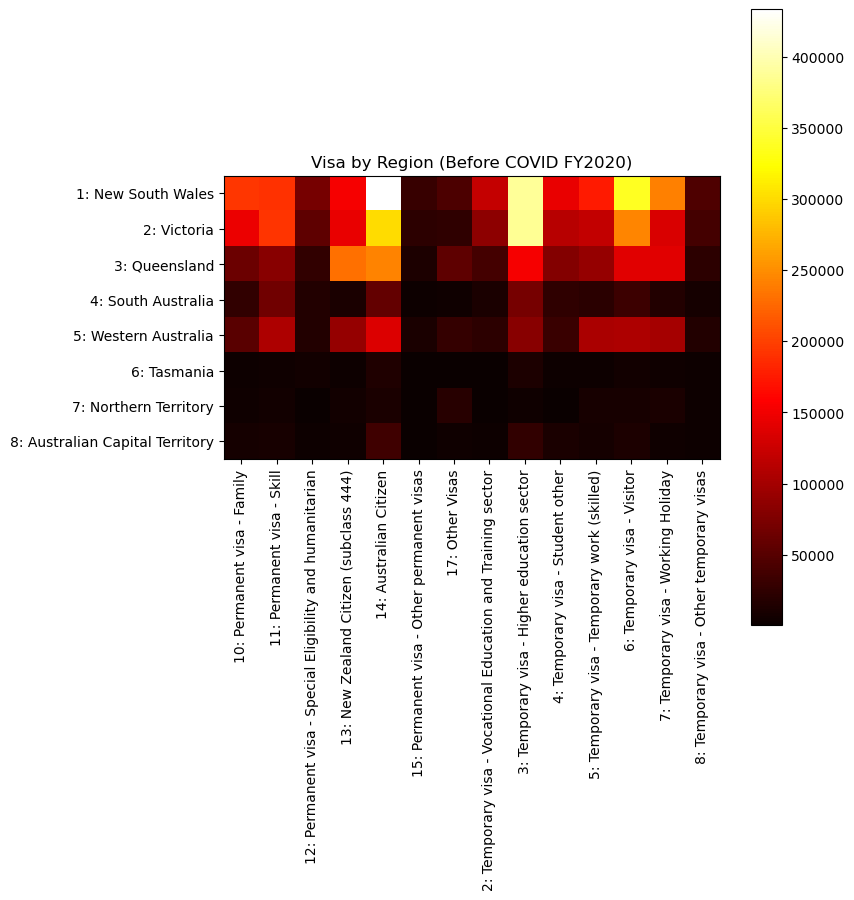

In [78]:
# Create a heat map before covid (code from project1)
plt.figure(figsize=(8, 8))
plt.imshow(visa_before_covid, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(visa_before_covid.columns)), visa_before_covid.columns, rotation = 90)
plt.yticks(range(len(visa_before_covid.index)), visa_before_covid.index)
plt.title("Visa by Region (Before COVID FY2020)")
plt.show()

In [76]:
# Visa data group before covid (code from project1)
visa_after_covid = clean_visa_type_df.loc[clean_visa_region_df["TIME_PERIOD: Time Period"] > 2020]
visa_after_covid = visa_after_covid.groupby(['REGION: Region','MEASURE: Type of Visa'])['OBS_VALUE'].sum()
visa_after_covid = visa_after_covid.reset_index()
visa_after_covid = visa_after_covid.pivot(index='REGION: Region', columns='MEASURE: Type of Visa', values='OBS_VALUE')
visa_after_covid

MEASURE: Type of Visa,10: Permanent visa - Family,11: Permanent visa - Skill,12: Permanent visa - Special Eligibility and humanitarian,13: New Zealand Citizen (subclass 444),14: Australian Citizen,15: Permanent visa - Other permanent visas,17: Other Visas,2: Temporary visa - Vocational Education and Training sector,3: Temporary visa - Higher education sector,4: Temporary visa - Student other,5: Temporary visa - Temporary work (skilled),6: Temporary visa - Visitor,7: Temporary visa - Working Holiday,8: Temporary visa - Other temporary visas
REGION: Region,,,,,,,,,,,,,,
1: New South Wales,16850,16020,3160,12900,54720,6300,940,10450,38130,7070,13730,17710,6230,12130
2: Victoria,11570,12720,2720,9910,26050,4090,680,4820,35240,6340,7150,14190,3470,8670
3: Queensland,5060,4670,810,11550,20070,1750,1110,2380,9590,3880,4370,6580,2880,7330
4: South Australia,2110,3470,620,700,4970,530,100,960,6290,1230,1200,2260,370,2140
5: Western Australia,3600,2870,370,4280,11360,1550,290,830,4380,1190,4150,4150,1190,3330
6: Tasmania,250,830,70,230,1080,60,20,190,930,190,260,450,70,2170
7: Northern Territory,310,570,80,290,920,110,660,140,380,90,300,450,230,1870
8: Australian Capital Territory,690,720,110,310,3310,220,140,320,2660,810,260,920,80,720


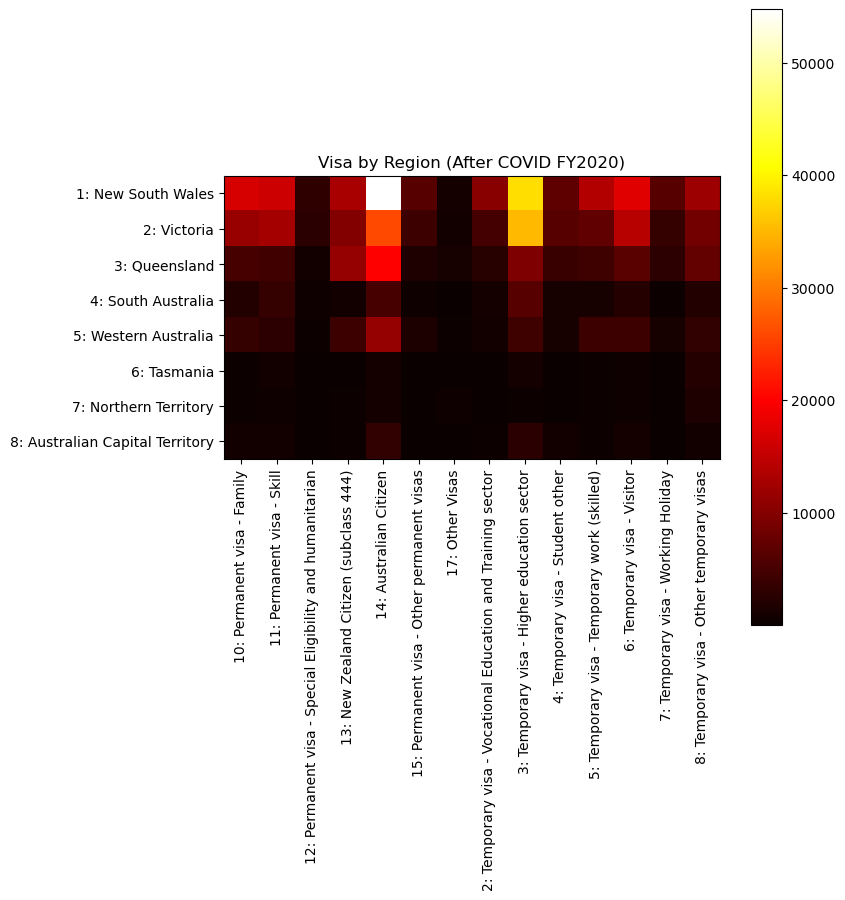

In [79]:
# Create a heat map after covid (code from project1)

plt.figure(figsize=(8, 8))
plt.imshow(visa_after_covid, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(visa_after_covid.columns)), visa_after_covid.columns, rotation = 90)
plt.yticks(range(len(visa_after_covid.index)), visa_after_covid.index)
plt.title("Visa by Region (After COVID FY2020)")
plt.show()